In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from zipfile import ZipFile
import os
from os import path
import shutil

In [ ]:
url = '/content/drive/MyDrive/4.2/soft-computing-lab/offline-2/'

In [ ]:
dataset_C = url + 'Dataset C.zip'
with ZipFile(dataset_C, 'r') as zip:
  zip.extractall()

In [ ]:
PATH = '/content/'
data_labels = pd.read_csv(PATH + 'training-c.csv', usecols = ['filename', 'digit'])
print(data_labels.shape)
data_labels.head()

(24298, 2)


,filename,digit
0,c00000.png,6
1,c00001.png,1
2,c00002.png,3
3,c00003.png,2
4,c00004.png,7


In [ ]:
TRAIN_PATH = url + 'Train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-c')

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(data_labels, TRAIN_PATH, train_transform)
test_data = Dataset(data_labels, TRAIN_PATH, test_transform)

print("Trainig Samples: ", len(train_data))

Trainig Samples:  24298


In [ ]:
# Base Parameters
batch_size = 200
num_iters = 25000
input_dim = 28*28
num_hidden = 200
output_dim = 10

learning_rate = 0.02

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

205


In [ ]:
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:98
Test dataloader:25


In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        self.linear_5= nn.Linear(num_hidden, num_hidden)
        self.relu_5= nn.ReLU()
 
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        #self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        out  = self.linear_5(out)
        out = self.relu_5(out)
 
        #out  = self.linear_6(out)
        #out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=200, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=200, out_features=200, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=200, out_features=200, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=200, out_features=200, bias=True)
  (relu_4): ReLU()
  (linear_5): Linear(in_features=200, out_features=200, bias=True)
  (relu_5): ReLU()
  (linear_out): Linear(in_features=200, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Iteration: 500. Loss: 1.3317309617996216. Accuracy: 47.17019962955341
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:  10
Epoch:  11
Iteration: 1000. Loss: 1.1915801763534546. Accuracy: 54.04404198394732
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 1500. Loss: 1.2454228401184082. Accuracy: 54.97015846882074
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:  20
Epoch:  21
Iteration: 2000. Loss: 1.1133147478103638. Accuracy: 59.41551759621321
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:  25
Epoch:  26
Iteration: 2500. Loss: 0.9969460964202881. Accuracy: 59.72422309117102
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Iteration: 3000. Loss: 1.1823807954788208. Accuracy: 58.96274953694176
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Iteration: 3500. Loss: 0.9197566509246826. Accuracy: 62.11154558551142
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Iteration: 4000. Loss: 1.0971390008926392. Accuracy: 62.317349

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4.2/soft-computing-lab/model_base6.pkl')
#

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/4.2/soft-computing-lab/model_base6.pkl'))

<All keys matched successfully>

[1.3317309617996216, 1.1915801763534546, 1.2454228401184082, 1.1133147478103638, 0.9969460964202881, 1.1823807954788208, 0.9197566509246826, 1.0971390008926392, 1.2023099660873413, 1.0948731899261475, 1.3344733715057373, 1.7064000368118286, 1.5191497802734375, 1.5898150205612183, 1.4458203315734863, 1.3990960121154785, 1.498732566833496, 1.5888720750808716, 1.6907687187194824, 1.632612943649292, 1.5874003171920776, 1.71708083152771, 1.5738654136657715, 1.7865475416183472, 1.7860733270645142, 1.7912743091583252, 1.692507028579712, 2.057851791381836, 2.059091567993164, 2.0980424880981445, 1.9457793235778809, 2.009096145629883, 2.144598960876465, 2.0320708751678467, 2.0289053916931152, 2.1330463886260986, 1.9923107624053955, 1.9991466999053955, 1.9454258680343628, 2.0360591411590576]


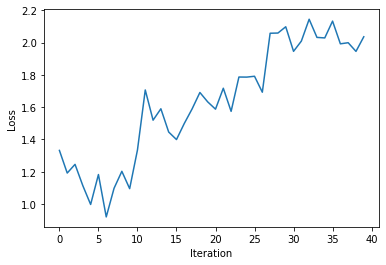

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# **7Th Iteration (FINAL)**

In [ ]:
# Base Parameters
batch_size = 122
num_iters = 20000
input_dim = 28*28
num_hidden = 220
output_dim = 10

learning_rate = 0.001

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

100


In [ ]:
###################################################################################
test_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
train_idx, test_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))

Train dataloader:160
Test dataloader:40


In [ ]:
###############################################################################
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
       
        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()
 
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.Softmax(dim=0)
 
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()
 
        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()
 
        #self.linear_5= nn.Linear(num_hidden, num_hidden)
        #self.relu_5= nn.ReLU()
 
        #self.linear_6 = nn.Linear(num_hidden, num_hidden)
        #self.relu_6 = nn.ReLU()
 
        self.linear_out = nn.Linear(num_hidden, num_classes)
 
    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)
 
        out  = self.linear_3(out)
        out = self.relu_3(out)
 
        out  = self.linear_4(out)
        out = self.relu_4(out)
 
        #out  = self.linear_5(out)
        #out = self.relu_5(out)
 
        #out  = self.linear_6(out)
        #out = self.relu_6(out)
        
        probas  = self.linear_out(out)
        return probas

In [ ]:
##########################################################################
model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)

model.to(device)

DeepNeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=220, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=220, out_features=220, bias=True)
  (relu_2): Softmax(dim=0)
  (linear_3): Linear(in_features=220, out_features=220, bias=True)
  (relu_3): ReLU()
  (linear_4): Linear(in_features=220, out_features=220, bias=True)
  (relu_4): ReLU()
  (linear_out): Linear(in_features=220, out_features=10, bias=True)
)

In [ ]:
##########################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:

#TRAINING 
###############################################################################
iteration_loss = []
iter = 0
for epoch in range(num_epochs):
    print('Epoch: ', epoch + 1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images) 

        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        iter += 1

        if iter % 500 == 0:        
            correct = 0
            total = 0
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                outputs = model(images)

                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            iteration_loss.append(loss.item())
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

########################################################################################

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Iteration: 500. Loss: 1.5440616607666016. Accuracy: 47.643548055155385
Epoch:  5
Epoch:  6
Epoch:  7
Iteration: 1000. Loss: 1.2066844701766968. Accuracy: 57.1105165671949
Epoch:  8
Epoch:  9
Epoch:  10
Iteration: 1500. Loss: 1.136793851852417. Accuracy: 66.0629759209714
Epoch:  11
Epoch:  12
Epoch:  13
Iteration: 2000. Loss: 0.8259464502334595. Accuracy: 70.77587981066063
Epoch:  14
Epoch:  15
Epoch:  16
Iteration: 2500. Loss: 0.5430208444595337. Accuracy: 73.20436303766208
Epoch:  17
Epoch:  18
Epoch:  19
Iteration: 3000. Loss: 0.40445682406425476. Accuracy: 76.25025725457913
Epoch:  20
Epoch:  21
Epoch:  22
Iteration: 3500. Loss: 0.446638286113739. Accuracy: 78.63757974891953
Epoch:  23
Epoch:  24
Epoch:  25
Iteration: 4000. Loss: 0.8633366823196411. Accuracy: 78.92570487754682
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Iteration: 4500. Loss: 0.30504313111305237. Accuracy: 79.2138300061741
Epoch:  30
Epoch:  31
Epoch:  32
Iteration: 5000. Loss

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/4.2/soft-computing-lab/offline-2/final_model.pkl')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/4.2/soft-computing-lab/offline-2/final_model.pkl'))

<All keys matched successfully>

[1.5440616607666016, 1.2066844701766968, 1.136793851852417, 0.8259464502334595, 0.5430208444595337, 0.40445682406425476, 0.446638286113739, 0.8633366823196411, 0.30504313111305237, 0.2292248010635376, 0.3081991374492645, 0.2822434902191162, 0.2672886550426483, 0.30514490604400635, 0.196772962808609, 0.5419579148292542, 0.21886354684829712, 0.07113496959209442, 0.12384185194969177, 0.1560022383928299, 0.1592598557472229, 0.08917999267578125, 0.07783985882997513, 0.3400851786136627, 0.11356843262910843, 0.0958070158958435, 0.1106514260172844, 0.07177221029996872, 0.03456857055425644, 0.04393868148326874, 0.16983692348003387, 0.11607957631349564]


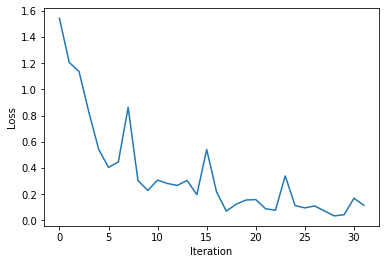

In [ ]:
print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()